In [1]:
import time
import os
import random
import numpy as np     
import math
import copy
from sympy import *
import sys

import matplotlib.pyplot as plt                                   
import autograd, autograd.core, autograd.extend, autograd.tracer  
import autograd.numpy as anp      
import scipy, scipy.ndimage, scipy.sparse, scipy.sparse.linalg 

from deap import base
from deap import creator
from deap import tools

import random
import matplotlib.pyplot as plt
import seaborn as sns


from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime

In [2]:
os.environ["OMP_NUM_THREADS"] = "5"  
os.environ["OPENBLAS_NUM_THREADS"] = "5"
os.environ["MKL_NUM_THREADS"] = "5"
os.environ["VECLIB_MAXIMUM_THREADS"] = "5"
os.environ["NUMEXPR_NUM_THREADS"] = "5"

In [3]:
sys.path.append('../../../../../ocean_intella/ocean_intella/pipelay_profile_optimization/')

In [4]:
import elitism

In [5]:
x0, y0, z0 = 4, 4, 8
dim3 = x0*y0+x0*z0+y0*z0

### Finite Element Model of the Linear Brick (Solid) Element

In [6]:
# not verified FE model

In [7]:
def LinearBrickElementVolume(x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4,x5,y5,z5,x6,y6,z6,x7,y7,z7,x8,y8,z8):
    s,t,u = symbols('s t u')
    N1 = (1-s)*(1-t)*(1+u)/8
    N2 = (1-s)*(1-t)*(1-u)/8
    N3 = (1-s)*(1+t)*(1-u)/8
    N4 = (1-s)*(1+t)*(1+u)/8
    N5 = (1+s)*(1-t)*(1+u)/8
    N6 = (1+s)*(1-t)*(1-u)/8
    N7 = (1+s)*(1+t)*(1-u)/8
    N8 = (1+s)*(1+t)*(1+u)/8
    x = N1*x1 + N2*x2 + N3*x3 + N4*x4 + N5*x5 + N6*x6 + N7*x7 + N8*x8
    y = N1*y1 + N2*y2 + N3*y3 + N4*y4 + N5*y5 + N6*y6 + N7*y7 + N8*y8
    z = N1*z1 + N2*z2 + N3*z3 + N4*z4 + N5*z5 + N6*z6 + N7*z7 + N8*z8
    xs = diff(x,s)
    xt = diff(x,t)
    xu = diff(x,u)
    ys = diff(y,s)
    yt = diff(y,t)
    yu = diff(y,u)
    zs = diff(z,s)
    zt = diff(z,t)
    zu = diff(z,u)
    J = xs*(yt*zu - zt*yu) - ys*(xt*zu - zt*xu) + zs*(xt*yu - yt*xu)
    Jnew = simplify(J)
    r = integrate(integrate(integrate(Jnew, (u, -1, 1)), (t, -1, 1)), (s, -1, 1))
    w = np.float64(r)
    return w

In [8]:
LinearBrickElementVolume(0,0,0.025,0,0,0,0,0.25,0,0,0.25,0.0,25,0.5,0,0.025,0.5,0,0,0.5,0.25,0,0.5,0.25)

0.4032812500000001

In [9]:
def LinearBrickElementStiffness(E,NU,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4,x5,y5,z5,x6,y6,z6,x7,y7,z7,x8,y8,z8):
    s,t,u = symbols('s t u')
    N1 = (1-s)*(1-t)*(1+u)/8
    N2 = (1-s)*(1-t)*(1-u)/8
    N3 = (1-s)*(1+t)*(1-u)/8
    N4 = (1-s)*(1+t)*(1+u)/8
    N5 = (1+s)*(1-t)*(1+u)/8
    N6 = (1+s)*(1-t)*(1-u)/8
    N7 = (1+s)*(1+t)*(1-u)/8
    N8 = (1+s)*(1+t)*(1+u)/8
    x = N1*x1 + N2*x2 + N3*x3 + N4*x4 + N5*x5 + N6*x6 + N7*x7 + N8*x8
    y = N1*y1 + N2*y2 + N3*y3 + N4*y4 + N5*y5 + N6*y6 + N7*y7 + N8*y8
    z = N1*z1 + N2*z2 + N3*z3 + N4*z4 + N5*z5 + N6*z6 + N7*z7 + N8*z8
    xs = diff(x,s)
    xt = diff(x,t)
    xu = diff(x,u)
    ys = diff(y,s)
    yt = diff(y,t)
    yu = diff(y,u)
    zs = diff(z,s)
    zt = diff(z,t)
    zu = diff(z,u)
    J = xs*(yt*zu - zt*yu) - ys*(xt*zu - zt*xu) + zs*(xt*yu - yt*xu)
    N1s = diff(N1,s)
    N2s = diff(N2,s)
    N3s = diff(N3,s)
    N4s = diff(N4,s)
    N5s = diff(N5,s)
    N6s = diff(N6,s)
    N7s = diff(N7,s)
    N8s = diff(N8,s)
    N1t = diff(N1,t)
    N2t = diff(N2,t)
    N3t = diff(N3,t)
    N4t = diff(N4,t)
    N5t = diff(N5,t)
    N6t = diff(N6,t)
    N7t = diff(N7,t)
    N8t = diff(N8,t)
    N1u = diff(N1,u)
    N2u = diff(N2,u)
    N3u = diff(N3,u)
    N4u = diff(N4,u)
    N5u = diff(N5,u)
    N6u = diff(N6,u)
    N7u = diff(N7,u)
    N8u = diff(N8,u)
    N1x = N1s*(yt*zu - zt*yu) - ys*(N1t*zu - zt*N1u) + zs*(N1t*yu - yt*N1u)
    N2x = N2s*(yt*zu - zt*yu) - ys*(N2t*zu - zt*N2u) + zs*(N2t*yu - yt*N2u)
    N3x = N3s*(yt*zu - zt*yu) - ys*(N3t*zu - zt*N3u) + zs*(N3t*yu - yt*N3u)
    N4x = N4s*(yt*zu - zt*yu) - ys*(N4t*zu - zt*N4u) + zs*(N4t*yu - yt*N4u)
    N5x = N5s*(yt*zu - zt*yu) - ys*(N5t*zu - zt*N5u) + zs*(N5t*yu - yt*N5u)
    N6x = N6s*(yt*zu - zt*yu) - ys*(N6t*zu - zt*N6u) + zs*(N6t*yu - yt*N6u)
    N7x = N7s*(yt*zu - zt*yu) - ys*(N7t*zu - zt*N7u) + zs*(N7t*yu - yt*N7u)
    N8x = N8s*(yt*zu - zt*yu) - ys*(N8t*zu - zt*N8u) + zs*(N8t*yu - yt*N8u)
    N1y = xs*(N1t*zu - zt*N1u) - N1s*(xt*zu - zt*xu) + zs*(xt*N1u - N1t*xu)
    N2y = xs*(N2t*zu - zt*N2u) - N2s*(xt*zu - zt*xu) + zs*(xt*N2u - N2t*xu)
    N3y = xs*(N3t*zu - zt*N3u) - N3s*(xt*zu - zt*xu) + zs*(xt*N3u - N3t*xu)
    N4y = xs*(N4t*zu - zt*N4u) - N4s*(xt*zu - zt*xu) + zs*(xt*N4u - N4t*xu)
    N5y = xs*(N5t*zu - zt*N5u) - N5s*(xt*zu - zt*xu) + zs*(xt*N5u - N5t*xu)
    N6y = xs*(N6t*zu - zt*N6u) - N6s*(xt*zu - zt*xu) + zs*(xt*N6u - N6t*xu)
    N7y = xs*(N7t*zu - zt*N7u) - N7s*(xt*zu - zt*xu) + zs*(xt*N7u - N7t*xu)
    N8y = xs*(N8t*zu - zt*N8u) - N8s*(xt*zu - zt*xu) + zs*(xt*N8u - N8t*xu)
    N1z = xs*(yt*N1u - N1t*yu) - ys*(xt*N1u - N1t*xu) + N1s*(xt*yu - yt*xu)
    N2z = xs*(yt*N2u - N2t*yu) - ys*(xt*N2u - N2t*xu) + N2s*(xt*yu - yt*xu)
    N3z = xs*(yt*N3u - N3t*yu) - ys*(xt*N3u - N3t*xu) + N3s*(xt*yu - yt*xu)
    N4z = xs*(yt*N4u - N4t*yu) - ys*(xt*N4u - N4t*xu) + N4s*(xt*yu - yt*xu)
    N5z = xs*(yt*N5u - N5t*yu) - ys*(xt*N5u - N5t*xu) + N5s*(xt*yu - yt*xu)
    N6z = xs*(yt*N6u - N6t*yu) - ys*(xt*N6u - N6t*xu) + N6s*(xt*yu - yt*xu)
    N7z = xs*(yt*N7u - N7t*yu) - ys*(xt*N7u - N7t*xu) + N7s*(xt*yu - yt*xu)
    N8z = xs*(yt*N8u - N8t*yu) - ys*(xt*N8u - N8t*xu) + N8s*(xt*yu - yt*xu)
    
    B = Matrix([[N1x, N2x, N3x, N4x, N5x, N6x, N7x, N8x, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ],
        [0, 0, 0, 0, 0, 0, 0, 0, N1y, N2y, N3y, N4y, N5y, N6y, N7y, N8y, 0, 0, 0, 0, 0, 0, 0, 0 ],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, N1z, N2z, N3z, N4z, N5z, N6z, N7z, N8z ],
        [N1y, N2y, N3y, N4y, N5y, N6y, N7y, N8y, N1x, N2x, N3x, N4x, N5x, N6x, N7x, N8x, 0, 0, 0, 0, 0, 0, 0, 0 ],
        [0, 0, 0, 0, 0, 0, 0, 0, N1z, N2z, N3z, N4z, N5z, N6z, N7z, N8z, N1y, N2y, N3y, N4y, N5y, N6y, N7y, N8y ],
        [N1z, N2z, N3z, N4z, N5z, N6z, N7z, N8z, 0, 0, 0, 0, 0, 0, 0, 0, N1x, N2x, N3x, N4x, N5x, N6x, N7x, N8x]])
    
    Bnew =B
    Jnew =J
    D = (E/((1+NU)*(1-2*NU)))*Matrix([[1-NU, NU, NU, 0, 0, 0 ], 
                                      [NU, 1-NU, NU, 0, 0, 0] , 
                                      [NU, NU, 1- NU, 0, 0, 0] ,
                                      [0, 0, 0, (1-2*NU)/2, 0, 0 ], 
                                      [0, 0, 0, 0, (1- 2*NU)/2, 0 ], 
                                      [0, 0, 0, 0, 0, (1- 2*NU)/2]])
   
    BD_ = (Bnew).T*D*Bnew/Jnew    
    BD = lambdify((s,t,u), BD_,'numpy')
    
    
    # Define Gauss Points and Weights (2-point quadrature for 8-node brick)
    G_LOC = 1.0 / np.sqrt(3.0)
    G_POINTS = [-G_LOC, G_LOC]
    G_WEIGHTS = [1.0, 1.0]
    
    
    w = np.zeros((24, 24)) 
    
    for i, Wi in enumerate(G_WEIGHTS):
        s_i = G_POINTS[i]
        for j, Wj in enumerate(G_WEIGHTS):
            t_j = G_POINTS[j]
            for k, Wk in enumerate(G_WEIGHTS):
                u_k = G_POINTS[k]
                
                W_total = Wi * Wj * Wk
                
                BD_matrix = BD(s_i, t_j, u_k)
                
                w += BD_matrix * W_total 
    return np.float64(w)

In [10]:
start_time = time.perf_counter()

ans=LinearBrickElementStiffness(210e6,0.3,0,0,0.025,0,0,0,0,0.25,0,0,0.25,0.0,25,0.5,0,0.025,0.5,0,0,0.5,0.25,0,0.5,0.25)

end_time = time.perf_counter()
elapsed_time = end_time - start_time

In [11]:
elapsed_time

11.649299542

In [12]:
ans.shape

(24, 24)

In [13]:
def LinearBrickAssemble(K,k,i,j,m,n,p,q,r,s):
    
    arr=copy.deepcopy(K)
    new_shape = tuple(s + 1 for s in arr.shape) 
    larger_arr = np.zeros(new_shape)

    larger_arr[1:arr.shape[0]+1, 1:arr.shape[1]+1] = arr
    
    K=copy.deepcopy(larger_arr)
    
    
    
    arr1=copy.deepcopy(k)
    new_shape1 = tuple(s + 1 for s in arr1.shape) 
    larger_arr1 = np.zeros(new_shape1)

    larger_arr1[1:arr1.shape[0]+1, 1:arr1.shape[1]+1] = arr1
    
    k=copy.deepcopy(larger_arr1)
    
    
    i+=1
    j+=1
    m+=1
    n+=1
    p+=1
    q+=1
    r+=1
    s+=1
    
    K[3*i-2,3*i-2] = K[3*i-2,3*i-2] + k[1,1]
    K[3*i-2,3*i-1] = K[3*i-2,3*i-1] + k[1,2]
    K[3*i-2,3*i] = K[3*i-2,3*i] + k[1,3]
    K[3*i-2,3*j-2] = K[3*i-2,3*j-2] + k[1,4]
    K[3*i-2,3*j-1] = K[3*i-2,3*j-1] + k[1,5]
    K[3*i-2,3*j] = K[3*i-2,3*j] + k[1,6]
    K[3*i-2,3*m-2] = K[3*i-2,3*m-2] + k[1,7]
    K[3*i-2,3*m-1] = K[3*i-2,3*m-1] + k[1,8]
    K[3*i-2,3*m] = K[3*i-2,3*m] + k[1,9]
    K[3*i-2,3*n-2] = K[3*i-2,3*n-2] + k[1,10]
    K[3*i-2,3*n-1] = K[3*i-2,3*n-1] + k[1,11]
    K[3*i-2,3*n] = K[3*i-2,3*n] + k[1,12]
    K[3*i-2,3*p-2] = K[3*i-2,3*p-2] + k[1,13]
    K[3*i-2,3*p-1] = K[3*i-2,3*p-1] + k[1,14]
    K[3*i-2,3*p] = K[3*i-2,3*p] + k[1,15]
    K[3*i-2,3*q-2] = K[3*i-2,3*q-2] + k[1,16]
    K[3*i-2,3*q-1] = K[3*i-2,3*q-1] + k[1,17]
    K[3*i-2,3*q] = K[3*i-2,3*q] + k[1,18]
    K[3*i-2,3*r-2] = K[3*i-2,3*r-2] + k[1,19]
    K[3*i-2,3*r-1] = K[3*i-2,3*r-1] + k[1,20]
    K[3*i-2,3*r] = K[3*i-2,3*r] + k[1,21]
    K[3*i-2,3*s-2] = K[3*i-2,3*s-2] + k[1,22]
    K[3*i-2,3*s-1] = K[3*i-2,3*s-1] + k[1,23]
    K[3*i-2,3*s] = K[3*i-2,3*s] + k[1,24]
    K[3*i-1,3*i-2] = K[3*i-1,3*i-2] + k[2,1]
    K[3*i-1,3*i-1] = K[3*i-1,3*i-1] + k[2,2]
    K[3*i-1,3*i] = K[3*i-1,3*i] + k[2,3]
    K[3*i-1,3*j-2] = K[3*i-1,3*j-2] + k[2,4]
    K[3*i-1,3*j-1] = K[3*i-1,3*j-1] + k[2,5]
    K[3*i-1,3*j] = K[3*i-1,3*j] + k[2,6]
    K[3*i-1,3*m-2] = K[3*i-1,3*m-2] + k[2,7]
    K[3*i-1,3*m-1] = K[3*i-1,3*m-1] + k[2,8]
    K[3*i-1,3*m] = K[3*i-1,3*m] + k[2,9]
    K[3*i-1,3*n-2] = K[3*i-1,3*n-2] + k[2,10]
    K[3*i-1,3*n-1] = K[3*i-1,3*n-1] + k[2,11]
    K[3*i-1,3*n] = K[3*i-1,3*n] + k[2,12]
    K[3*i-1,3*p-2] = K[3*i-1,3*p-2] + k[2,13]
    K[3*i-1,3*p-1] = K[3*i-1,3*p-1] + k[2,14]
    K[3*i-1,3*p] = K[3*i-1,3*p] + k[2,15]
    K[3*i-1,3*q-2] = K[3*i-1,3*q-2] + k[2,16]
    K[3*i-1,3*q-1] = K[3*i-1,3*q-1] + k[2,17]
    K[3*i-1,3*q] = K[3*i-1,3*q] + k[2,18]
    K[3*i-1,3*r-2] = K[3*i-1,3*r-2] + k[2,19]
    K[3*i-1,3*r-1] = K[3*i-1,3*r-1] + k[2,20]
    K[3*i-1,3*r] = K[3*i-1,3*r] + k[2,21]
    K[3*i-1,3*s-2] = K[3*i-1,3*s-2] + k[2,22]
    K[3*i-1,3*s-1] = K[3*i-1,3*s-1] + k[2,23]
    K[3*i-1,3*s] = K[3*i-1,3*s] + k[2,24]
    K[3*i,3*i-2] = K[3*i,3*i-2] + k[3,1]
    K[3*i,3*i-1] = K[3*i,3*i-1] + k[3,2]
    K[3*i,3*i] = K[3*i,3*i] + k[3,3]
    K[3*i,3*j-2] = K[3*i,3*j-2] + k[3,4]
    K[3*i,3*j-1] = K[3*i,3*j-1] + k[3,5]
    K[3*i,3*j] = K[3*i,3*j] + k[3,6]
    K[3*i,3*m-2] = K[3*i,3*m-2] + k[3,7]
    K[3*i,3*m-1] = K[3*i,3*m-1] + k[3,8]
    K[3*i,3*m] = K[3*i,3*m] + k[3,9]
    K[3*i,3*n-2] = K[3*i,3*n-2] + k[3,10]
    K[3*i,3*n-1] = K[3*i,3*n-1] + k[3,11]
    K[3*i,3*n] = K[3*i,3*n] + k[3,12]
    K[3*i,3*p-2] = K[3*i,3*p-2] + k[3,13]
    K[3*i,3*p-1] = K[3*i,3*p-1] + k[3,14]
    K[3*i,3*p] = K[3*i,3*p] + k[3,15]
    K[3*i,3*q-2] = K[3*i,3*q-2] + k[3,16]
    K[3*i,3*q-1] = K[3*i,3*q-1] + k[3,17]
    K[3*i,3*q] = K[3*i,3*q] + k[3,18]
    K[3*i,3*r-2] = K[3*i,3*r-2] + k[3,19]
    K[3*i,3*r-1] = K[3*i,3*r-1] + k[3,20]
    K[3*i,3*r] = K[3*i,3*r] + k[3,21]
    K[3*i,3*s-2] = K[3*i,3*s-2] + k[3,22]
    K[3*i,3*s-1] = K[3*i,3*s-1] + k[3,23]
    K[3*i,3*s] = K[3*i,3*s] + k[3,24]
    K[3*j-2,3*i-2] = K[3*j-2,3*i-2] + k[4,1]
    K[3*j-2,3*i-1] = K[3*j-2,3*i-1] + k[4,2]
    K[3*j-2,3*i] = K[3*j-2,3*i] + k[4,3]
    K[3*j-2,3*j-2] = K[3*j-2,3*j-2] + k[4,4]
    K[3*j-2,3*j-1] = K[3*j-2,3*j-1] + k[4,5]
    K[3*j-2,3*j] = K[3*j-2,3*j] + k[4,6]
    K[3*j-2,3*m-2] = K[3*j-2,3*m-2] + k[4,7]
    K[3*j-2,3*m-1] = K[3*j-2,3*m-1] + k[4,8]
    K[3*j-2,3*m] = K[3*j-2,3*m] + k[4,9]
    K[3*j-2,3*n-2] = K[3*j-2,3*n-2] + k[4,10]
    K[3*j-2,3*n-1] = K[3*j-2,3*n-1] + k[4,11]
    K[3*j-2,3*n] = K[3*j-2,3*n] + k[4,12]
    K[3*j-2,3*p-2] = K[3*j-2,3*p-2] + k[4,13]
    K[3*j-2,3*p-1] = K[3*j-2,3*p-1] + k[4,14]
    K[3*j-2,3*p] = K[3*j-2,3*p] + k[4,15]
    K[3*j-2,3*q-2] = K[3*j-2,3*q-2] + k[4,16]
    K[3*j-2,3*q-1] = K[3*j-2,3*q-1] + k[4,17]
    K[3*j-2,3*q] = K[3*j-2,3*q] + k[4,18]
    K[3*j-2,3*r-2] = K[3*j-2,3*r-2] + k[4,19]
    K[3*j-2,3*r-1] = K[3*j-2,3*r-1] + k[4,20]
    K[3*j-2,3*r] = K[3*j-2,3*r] + k[4,21]
    K[3*j-2,3*s-2] = K[3*j-2,3*s-2] + k[4,22]
    K[3*j-2,3*s-1] = K[3*j-2,3*s-1] + k[4,23]
    K[3*j-2,3*s] = K[3*j-2,3*s] + k[4,24]
    K[3*j-1,3*i-2] = K[3*j-1,3*i-2] + k[5,1]
    K[3*j-1,3*i-1] = K[3*j-1,3*i-1] + k[5,2]
    K[3*j-1,3*i] = K[3*j-1,3*i] + k[5,3]
    K[3*j-1,3*j-2] = K[3*j-1,3*j-2] + k[5,4]
    K[3*j-1,3*j-1] = K[3*j-1,3*j-1] + k[5,5]
    K[3*j-1,3*j] = K[3*j-1,3*j] + k[5,6]
    K[3*j-1,3*m-2] = K[3*j-1,3*m-2] + k[5,7]
    K[3*j-1,3*m-1] = K[3*j-1,3*m-1] + k[5,8]
    K[3*j-1,3*m] = K[3*j-1,3*m] + k[5,9]
    K[3*j-1,3*n-2] = K[3*j-1,3*n-2] + k[5,10]
    K[3*j-1,3*n-1] = K[3*j-1,3*n-1] + k[5,11]
    K[3*j-1,3*n] = K[3*j-1,3*n] + k[5,12]
    K[3*j-1,3*p-2] = K[3*j-1,3*p-2] + k[5,13]
    K[3*j-1,3*p-1] = K[3*j-1,3*p-1] + k[5,14]
    K[3*j-1,3*p] = K[3*j-1,3*p] + k[5,15]
    K[3*j-1,3*q-2] = K[3*j-1,3*q-2] + k[5,16]
    K[3*j-1,3*q-1] = K[3*j-1,3*q-1] + k[5,17]
    K[3*j-1,3*q] = K[3*j-1,3*q] + k[5,18]
    K[3*j-1,3*r-2] = K[3*j-1,3*r-2] + k[5,19]
    K[3*j-1,3*r-1] = K[3*j-1,3*r-1] + k[5,20]
    K[3*j-1,3*r] = K[3*j-1,3*r] + k[5,21]
    K[3*j-1,3*s-2] = K[3*j-1,3*s-2] + k[5,22]
    K[3*j-1,3*s-1] = K[3*j-1,3*s-1] + k[5,23]
    K[3*j-1,3*s] = K[3*j-1,3*s] + k[5,24]
    K[3*j,3*i-2] = K[3*j,3*i-2] + k[6,1]
    K[3*j,3*i-1] = K[3*j,3*i-1] + k[6,2]
    K[3*j,3*i] = K[3*j,3*i] + k[6,3]
    K[3*j,3*j-2] = K[3*j,3*j-2] + k[6,4]
    K[3*j,3*j-1] = K[3*j,3*j-1] + k[6,5]
    K[3*j,3*j] = K[3*j,3*j] + k[6,6]
    K[3*j,3*m-2] = K[3*j,3*m-2] + k[6,7]
    K[3*j,3*m-1] = K[3*j,3*m-1] + k[6,8]
    K[3*j,3*m] = K[3*j,3*m] + k[6,9]
    K[3*j,3*n-2] = K[3*j,3*n-2] + k[6,10]
    K[3*j,3*n-1] = K[3*j,3*n-1] + k[6,11]
    K[3*j,3*n] = K[3*j,3*n] + k[6,12]
    K[3*j,3*p-2] = K[3*j,3*p-2] + k[6,13]
    K[3*j,3*p-1] = K[3*j,3*p-1] + k[6,14]
    K[3*j,3*p] = K[3*j,3*p] + k[6,15]
    K[3*j,3*q-2] = K[3*j,3*q-2] + k[6,16]
    K[3*j,3*q-1] = K[3*j,3*q-1] + k[6,17]
    K[3*j,3*q] = K[3*j,3*q] + k[6,18]
    K[3*j,3*r-2] = K[3*j,3*r-2] + k[6,19]
    K[3*j,3*r-1] = K[3*j,3*r-1] + k[6,20]
    K[3*j,3*r] = K[3*j,3*r] + k[6,21]
    K[3*j,3*s-2] = K[3*j,3*s-2] + k[6,22]
    K[3*j,3*s-1] = K[3*j,3*s-1] + k[6,23]
    K[3*j,3*s] = K[3*j,3*s] + k[6,24]
    K[3*m-2,3*i-2] = K[3*m-2,3*i-2] + k[7,1]
    K[3*m-2,3*i-1] = K[3*m-2,3*i-1] + k[7,2]
    K[3*m-2,3*i] = K[3*m-2,3*i] + k[7,3]
    K[3*m-2,3*j-2] = K[3*m-2,3*j-2] + k[7,4]
    K[3*m-2,3*j-1] = K[3*m-2,3*j-1] + k[7,5]
    K[3*m-2,3*j] = K[3*m-2,3*j] + k[7,6]
    K[3*m-2,3*m-2] = K[3*m-2,3*m-2] + k[7,7]
    K[3*m-2,3*m-1] = K[3*m-2,3*m-1] + k[7,8]
    K[3*m-2,3*m] = K[3*m-2,3*m] + k[7,9]
    K[3*m-2,3*n-2] = K[3*m-2,3*n-2] + k[7,10]
    K[3*m-2,3*n-1] = K[3*m-2,3*n-1] + k[7,11]
    K[3*m-2,3*n] = K[3*m-2,3*n] + k[7,12]
    K[3*m-2,3*p-2] = K[3*m-2,3*p-2] + k[7,13]
    K[3*m-2,3*p-1] = K[3*m-2,3*p-1] + k[7,14]
    K[3*m-2,3*p] = K[3*m-2,3*p] + k[7,15]
    K[3*m-2,3*q-2] = K[3*m-2,3*q-2] + k[7,16]
    K[3*m-2,3*q-1] = K[3*m-2,3*q-1] + k[7,17]
    K[3*m-2,3*q] = K[3*m-2,3*q] + k[7,18]
    K[3*m-2,3*r-2] = K[3*m-2,3*r-2] + k[7,19]
    K[3*m-2,3*r-1] = K[3*m-2,3*r-1] + k[7,20]
    K[3*m-2,3*r] = K[3*m-2,3*r] + k[7,21]
    K[3*m-2,3*s-2] = K[3*m-2,3*s-2] + k[7,22]
    K[3*m-2,3*s-1] = K[3*m-2,3*s-1] + k[7,23]
    K[3*m-2,3*s] = K[3*m-2,3*s] + k[7,24]
    K[3*m-1,3*i-2] = K[3*m-1,3*i-2] + k[8,1]
    K[3*m-1,3*i-1] = K[3*m-1,3*i-1] + k[8,2]
    K[3*m-1,3*i] = K[3*m-1,3*i] + k[8,3]
    K[3*m-1,3*j-2] = K[3*m-1,3*j-2] + k[8,4]
    K[3*m-1,3*j-1] = K[3*m-1,3*j-1] + k[8,5]
    K[3*m-1,3*j] = K[3*m-1,3*j] + k[8,6]
    K[3*m-1,3*m-2] = K[3*m-1,3*m-2] + k[8,7]
    K[3*m-1,3*m-1] = K[3*m-1,3*m-1] + k[8,8]
    K[3*m-1,3*m] = K[3*m-1,3*m] + k[8,9]
    K[3*m-1,3*n-2] = K[3*m-1,3*n-2] + k[8,10]
    K[3*m-1,3*n-1] = K[3*m-1,3*n-1] + k[8,11]
    K[3*m-1,3*n] = K[3*m-1,3*n] + k[8,12]
    K[3*m-1,3*p-2] = K[3*m-1,3*p-2] + k[8,13]
    K[3*m-1,3*p-1] = K[3*m-1,3*p-1] + k[8,14]
    K[3*m-1,3*p] = K[3*m-1,3*p] + k[8,15]
    K[3*m-1,3*q-2] = K[3*m-1,3*q-2] + k[8,16]
    K[3*m-1,3*q-1] = K[3*m-1,3*q-1] + k[8,17]
    K[3*m-1,3*q] = K[3*m-1,3*q] + k[8,18]
    K[3*m-1,3*r-2] = K[3*m-1,3*r-2] + k[8,19]
    K[3*m-1,3*r-1] = K[3*m-1,3*r-1] + k[8,20]
    K[3*m-1,3*r] = K[3*m-1,3*r] + k[8,21]
    K[3*m-1,3*s-2] = K[3*m-1,3*s-2] + k[8,22]
    K[3*m-1,3*s-1] = K[3*m-1,3*s-1] + k[8,23]
    K[3*m-1,3*s] = K[3*m-1,3*s] + k[8,24]
    K[3*m,3*i-2] = K[3*m,3*i-2] + k[9,1]
    K[3*m,3*i-1] = K[3*m,3*i-1] + k[9,2]
    K[3*m,3*i] = K[3*m,3*i] + k[9,3]
    K[3*m,3*j-2] = K[3*m,3*j-2] + k[9,4]
    K[3*m,3*j-1] = K[3*m,3*j-1] + k[9,5]
    K[3*m,3*j] = K[3*m,3*j] + k[9,6]
    K[3*m,3*m-2] = K[3*m,3*m-2] + k[9,7]
    K[3*m,3*m-1] = K[3*m,3*m-1] + k[9,8]
    K[3*m,3*m] = K[3*m,3*m] + k[9,9]
    K[3*m,3*n-2] = K[3*m,3*n-2] + k[9,10]
    K[3*m,3*n-1] = K[3*m,3*n-1] + k[9,11]
    K[3*m,3*n] = K[3*m,3*n] + k[9,12]
    K[3*m,3*p-2] = K[3*m,3*p-2] + k[9,13]
    K[3*m,3*p-1] = K[3*m,3*p-1] + k[9,14]
    K[3*m,3*p] = K[3*m,3*p] + k[9,15]
    K[3*m,3*q-2] = K[3*m,3*q-2] + k[9,16]
    K[3*m,3*q-1] = K[3*m,3*q-1] + k[9,17]
    K[3*m,3*q] = K[3*m,3*q] + k[9,18]
    K[3*m,3*r-2] = K[3*m,3*r-2] + k[9,19]
    K[3*m,3*r-1] = K[3*m,3*r-1] + k[9,20]
    K[3*m,3*r] = K[3*m,3*r] + k[9,21]
    K[3*m,3*s-2] = K[3*m,3*s-2] + k[9,22]
    K[3*m,3*s-1] = K[3*m,3*s-1] + k[9,23]
    K[3*m,3*s] = K[3*m,3*s] + k[9,24]
    K[3*n-2,3*i-2] = K[3*n-2,3*i-2] + k[10,1]
    K[3*n-2,3*i-1] = K[3*n-2,3*i-1] + k[10,2]
    K[3*n-2,3*i] = K[3*n-2,3*i] + k[10,3]
    K[3*n-2,3*j-2] = K[3*n-2,3*j-2] + k[10,4]
    K[3*n-2,3*j-1] = K[3*n-2,3*j-1] + k[10,5]
    K[3*n-2,3*j] = K[3*n-2,3*j] + k[10,6]
    K[3*n-2,3*m-2] = K[3*n-2,3*m-2] + k[10,7]
    K[3*n-2,3*m-1] = K[3*n-2,3*m-1] + k[10,8]
    K[3*n-2,3*m] = K[3*n-2,3*m] + k[10,9]
    K[3*n-2,3*n-2] = K[3*n-2,3*n-2] + k[10,10]
    K[3*n-2,3*n-1] = K[3*n-2,3*n-1] + k[10,11]
    K[3*n-2,3*n] = K[3*n-2,3*n] + k[10,12]
    K[3*n-2,3*p-2] = K[3*n-2,3*p-2] + k[10,13]
    K[3*n-2,3*p-1] = K[3*n-2,3*p-1] + k[10,14]
    K[3*n-2,3*p] = K[3*n-2,3*p] + k[10,15]
    K[3*n-2,3*q-2] = K[3*n-2,3*q-2] + k[10,16]
    K[3*n-2,3*q-1] = K[3*n-2,3*q-1] + k[10,17]
    K[3*n-2,3*q] = K[3*n-2,3*q] + k[10,18]
    K[3*n-2,3*r-2] = K[3*n-2,3*r-2] + k[10,19]
    K[3*n-2,3*r-1] = K[3*n-2,3*r-1] + k[10,20]
    K[3*n-2,3*r] = K[3*n-2,3*r] + k[10,21]
    K[3*n-2,3*s-2] = K[3*n-2,3*s-2] + k[10,22]
    K[3*n-2,3*s-1] = K[3*n-2,3*s-1] + k[10,23]
    K[3*n-2,3*s] = K[3*n-2,3*s] + k[10,24]
    K[3*n-1,3*i-2] = K[3*n-1,3*i-2] + k[11,1]
    K[3*n-1,3*i-1] = K[3*n-1,3*i-1] + k[11,2]
    K[3*n-1,3*i] = K[3*n-1,3*i] + k[11,3]
    K[3*n-1,3*j-2] = K[3*n-1,3*j-2] + k[11,4]
    K[3*n-1,3*j-1] = K[3*n-1,3*j-1] + k[11,5]
    K[3*n-1,3*j] = K[3*n-1,3*j] + k[11,6]
    K[3*n-1,3*m-2] = K[3*n-1,3*m-2] + k[11,7]
    K[3*n-1,3*m-1] = K[3*n-1,3*m-1] + k[11,8]
    K[3*n-1,3*m] = K[3*n-1,3*m] + k[11,9]
    K[3*n-1,3*n-2] = K[3*n-1,3*n-2] + k[11,10]
    K[3*n-1,3*n-1] = K[3*n-1,3*n-1] + k[11,11]
    K[3*n-1,3*n] = K[3*n-1,3*n] + k[11,12]
    K[3*n-1,3*p-2] = K[3*n-1,3*p-2] + k[11,13]
    K[3*n-1,3*p-1] = K[3*n-1,3*p-1] + k[11,14]
    K[3*n-1,3*p] = K[3*n-1,3*p] + k[11,15]
    K[3*n-1,3*q-2] = K[3*n-1,3*q-2] + k[11,16]
    K[3*n-1,3*q-1] = K[3*n-1,3*q-1] + k[11,17]
    K[3*n-1,3*q] = K[3*n-1,3*q] + k[11,18]
    K[3*n-1,3*r-2] = K[3*n-1,3*r-2] + k[11,19]
    K[3*n-1,3*r-1] = K[3*n-1,3*r-1] + k[11,20]
    K[3*n-1,3*r] = K[3*n-1,3*r] + k[11,21]
    K[3*n-1,3*s-2] = K[3*n-1,3*s-2] + k[11,22]
    K[3*n-1,3*s-1] = K[3*n-1,3*s-1] + k[11,23]
    K[3*n-1,3*s] = K[3*n-1,3*s] + k[11,24]
    K[3*n,3*i-2] = K[3*n,3*i-2] + k[12,1]
    K[3*n,3*i-1] = K[3*n,3*i-1] + k[12,2]
    K[3*n,3*i] = K[3*n,3*i] + k[12,3]
    K[3*n,3*j-2] = K[3*n,3*j-2] + k[12,4]
    K[3*n,3*j-1] = K[3*n,3*j-1] + k[12,5]
    K[3*n,3*j] = K[3*n,3*j] + k[12,6]
    K[3*n,3*m-2] = K[3*n,3*m-2] + k[12,7]
    K[3*n,3*m-1] = K[3*n,3*m-1] + k[12,8]
    K[3*n,3*m] = K[3*n,3*m] + k[12,9]
    K[3*n,3*n-2] = K[3*n,3*n-2] + k[12,10]
    K[3*n,3*n-1] = K[3*n,3*n-1] + k[12,11]
    K[3*n,3*n] = K[3*n,3*n] + k[12,12]
    K[3*n,3*p-2] = K[3*n,3*p-2] + k[12,13]
    K[3*n,3*p-1] = K[3*n,3*p-1] + k[12,14]
    K[3*n,3*p] = K[3*n,3*p] + k[12,15]
    K[3*n,3*q-2] = K[3*n,3*q-2] + k[12,16]
    K[3*n,3*q-1] = K[3*n,3*q-1] + k[12,17]
    K[3*n,3*q] = K[3*n,3*q] + k[12,18]
    K[3*n,3*r-2] = K[3*n,3*r-2] + k[12,19]
    K[3*n,3*r-1] = K[3*n,3*r-1] + k[12,20]
    K[3*n,3*r] = K[3*n,3*r] + k[12,21]
    K[3*n,3*s-2] = K[3*n,3*s-2] + k[12,22]
    K[3*n,3*s-1] = K[3*n,3*s-1] + k[12,23]
    K[3*n,3*s] = K[3*n,3*s] + k[12,24]
    K[3*p-2,3*i-2] = K[3*p-2,3*i-2] + k[13,1]
    K[3*p-2,3*i-1] = K[3*p-2,3*i-1] + k[13,2]
    K[3*p-2,3*i] = K[3*p-2,3*i] + k[13,3]
    K[3*p-2,3*j-2] = K[3*p-2,3*j-2] + k[13,4]
    K[3*p-2,3*j-1] = K[3*p-2,3*j-1] + k[13,5]
    K[3*p-2,3*j] = K[3*p-2,3*j] + k[13,6]
    K[3*p-2,3*m-2] = K[3*p-2,3*m-2] + k[13,7]
    K[3*p-2,3*m-1] = K[3*p-2,3*m-1] + k[13,8]
    K[3*p-2,3*m] = K[3*p-2,3*m] + k[13,9]
    K[3*p-2,3*n-2] = K[3*p-2,3*n-2] + k[13,10]
    K[3*p-2,3*n-1] = K[3*p-2,3*n-1] + k[13,11]
    K[3*p-2,3*n] = K[3*p-2,3*n] + k[13,12]
    K[3*p-2,3*p-2] = K[3*p-2,3*p-2] + k[13,13]
    K[3*p-2,3*p-1] = K[3*p-2,3*p-1] + k[13,14]
    K[3*p-2,3*p] = K[3*p-2,3*p] + k[13,15]
    K[3*p-2,3*q-2] = K[3*p-2,3*q-2] + k[13,16]
    K[3*p-2,3*q-1] = K[3*p-2,3*q-1] + k[13,17]
    K[3*p-2,3*q] = K[3*p-2,3*q] + k[13,18]
    K[3*p-2,3*r-2] = K[3*p-2,3*r-2] + k[13,19]
    K[3*p-2,3*r-1] = K[3*p-2,3*r-1] + k[13,20]
    K[3*p-2,3*r] = K[3*p-2,3*r] + k[13,21]
    K[3*p-2,3*s-2] = K[3*p-2,3*s-2] + k[13,22]
    K[3*p-2,3*s-1] = K[3*p-2,3*s-1] + k[13,23]
    K[3*p-2,3*s] = K[3*p-2,3*s] + k[13,24]
    K[3*p-1,3*i-2] = K[3*p-1,3*i-2] + k[14,1]
    K[3*p-1,3*i-1] = K[3*p-1,3*i-1] + k[14,2]
    K[3*p-1,3*i] = K[3*p-1,3*i] + k[14,3]
    K[3*p-1,3*j-2] = K[3*p-1,3*j-2] + k[14,4]
    K[3*p-1,3*j-1] = K[3*p-1,3*j-1] + k[14,5]
    K[3*p-1,3*j] = K[3*p-1,3*j] + k[14,6]
    K[3*p-1,3*m-2] = K[3*p-1,3*m-2] + k[14,7]
    K[3*p-1,3*m-1] = K[3*p-1,3*m-1] + k[14,8]
    K[3*p-1,3*m] = K[3*p-1,3*m] + k[14,9]
    K[3*p-1,3*n-2] = K[3*p-1,3*n-2] + k[14,10]
    K[3*p-1,3*n-1] = K[3*p-1,3*n-1] + k[14,11]
    K[3*p-1,3*n] = K[3*p-1,3*n] + k[14,12]
    K[3*p-1,3*p-2] = K[3*p-1,3*p-2] + k[14,13]
    K[3*p-1,3*p-1] = K[3*p-1,3*p-1] + k[14,14]
    K[3*p-1,3*p] = K[3*p-1,3*p] + k[14,15]
    K[3*p-1,3*q-2] = K[3*p-1,3*q-2] + k[14,16]
    K[3*p-1,3*q-1] = K[3*p-1,3*q-1] + k[14,17]
    K[3*p-1,3*q] = K[3*p-1,3*q] + k[14,18]
    K[3*p-1,3*r-2] = K[3*p-1,3*r-2] + k[14,19]
    K[3*p-1,3*r-1] = K[3*p-1,3*r-1] + k[14,20]
    K[3*p-1,3*r] = K[3*p-1,3*r] + k[14,21]
    K[3*p-1,3*s-2] = K[3*p-1,3*s-2] + k[14,22]
    K[3*p-1,3*s-1] = K[3*p-1,3*s-1] + k[14,23]
    K[3*p-1,3*s] = K[3*p-1,3*s] + k[14,24]
    K[3*p,3*i-2] = K[3*p,3*i-2] + k[15,1]
    K[3*p,3*i-1] = K[3*p,3*i-1] + k[15,2]
    K[3*p,3*i] = K[3*p,3*i] + k[15,3]
    K[3*p,3*j-2] = K[3*p,3*j-2] + k[15,4]
    K[3*p,3*j-1] = K[3*p,3*j-1] + k[15,5]
    K[3*p,3*j] = K[3*p,3*j] + k[15,6]
    K[3*p,3*m-2] = K[3*p,3*m-2] + k[15,7]
    K[3*p,3*m-1] = K[3*p,3*m-1] + k[15,8]
    K[3*p,3*m] = K[3*p,3*m] + k[15,9]
    K[3*p,3*n-2] = K[3*p,3*n-2] + k[15,10]
    K[3*p,3*n-1] = K[3*p,3*n-1] + k[15,11]
    K[3*p,3*n] = K[3*p,3*n] + k[15,12]
    K[3*p,3*p-2] = K[3*p,3*p-2] + k[15,13]
    K[3*p,3*p-1] = K[3*p,3*p-1] + k[15,14]
    K[3*p,3*p] = K[3*p,3*p] + k[15,15]
    K[3*p,3*q-2] = K[3*p,3*q-2] + k[15,16]
    K[3*p,3*q-1] = K[3*p,3*q-1] + k[15,17]
    K[3*p,3*q] = K[3*p,3*q] + k[15,18]
    K[3*p,3*r-2] = K[3*p,3*r-2] + k[15,19]
    K[3*p,3*r-1] = K[3*p,3*r-1] + k[15,20]
    K[3*p,3*r] = K[3*p,3*r] + k[15,21]
    K[3*p,3*s-2] = K[3*p,3*s-2] + k[15,22]
    K[3*p,3*s-1] = K[3*p,3*s-1] + k[15,23]
    K[3*p,3*s] = K[3*p,3*s] + k[15,24]
    K[3*q-2,3*i-2] = K[3*q-2,3*i-2] + k[16,1]
    K[3*q-2,3*i-1] = K[3*q-2,3*i-1] + k[16,2]
    K[3*q-2,3*i] = K[3*q-2,3*i] + k[16,3]
    K[3*q-2,3*j-2] = K[3*q-2,3*j-2] + k[16,4]
    K[3*q-2,3*j-1] = K[3*q-2,3*j-1] + k[16,5]
    K[3*q-2,3*j] = K[3*q-2,3*j] + k[16,6]
    K[3*q-2,3*m-2] = K[3*q-2,3*m-2] + k[16,7]
    K[3*q-2,3*m-1] = K[3*q-2,3*m-1] + k[16,8]
    K[3*q-2,3*m] = K[3*q-2,3*m] + k[16,9]
    K[3*q-2,3*n-2] = K[3*q-2,3*n-2] + k[16,10]
    K[3*q-2,3*n-1] = K[3*q-2,3*n-1] + k[16,11]
    K[3*q-2,3*n] = K[3*q-2,3*n] + k[16,12]
    K[3*q-2,3*p-2] = K[3*q-2,3*p-2] + k[16,13]
    K[3*q-2,3*p-1] = K[3*q-2,3*p-1] + k[16,14]
    K[3*q-2,3*p] = K[3*q-2,3*p] + k[16,15]
    K[3*q-2,3*q-2] = K[3*q-2,3*q-2] + k[16,16]
    K[3*q-2,3*q-1] = K[3*q-2,3*q-1] + k[16,17]
    K[3*q-2,3*q] = K[3*q-2,3*q] + k[16,18]
    K[3*q-2,3*r-2] = K[3*q-2,3*r-2] + k[16,19]
    K[3*q-2,3*r-1] = K[3*q-2,3*r-1] + k[16,20]
    K[3*q-2,3*r] = K[3*q-2,3*r] + k[16,21]
    K[3*q-2,3*s-2] = K[3*q-2,3*s-2] + k[16,22]
    K[3*q-2,3*s-1] = K[3*q-2,3*s-1] + k[16,23]
    K[3*q-2,3*s] = K[3*q-2,3*s] + k[16,24]
    K[3*q-1,3*i-2] = K[3*q-1,3*i-2] + k[17,1]
    K[3*q-1,3*i-1] = K[3*q-1,3*i-1] + k[17,2]
    K[3*q-1,3*i] = K[3*q-1,3*i] + k[17,3]
    K[3*q-1,3*j-2] = K[3*q-1,3*j-2] + k[17,4]
    K[3*q-1,3*j-1] = K[3*q-1,3*j-1] + k[17,5]
    K[3*q-1,3*j] = K[3*q-1,3*j] + k[17,6]
    K[3*q-1,3*m-2] = K[3*q-1,3*m-2] + k[17,7]
    K[3*q-1,3*m-1] = K[3*q-1,3*m-1] + k[17,8]
    K[3*q-1,3*m] = K[3*q-1,3*m] + k[17,9]
    K[3*q-1,3*n-2] = K[3*q-1,3*n-2] + k[17,10]
    K[3*q-1,3*n-1] = K[3*q-1,3*n-1] + k[17,11]
    K[3*q-1,3*n] = K[3*q-1,3*n] + k[17,12]
    K[3*q-1,3*p-2] = K[3*q-1,3*p-2] + k[17,13]
    K[3*q-1,3*p-1] = K[3*q-1,3*p-1] + k[17,14]
    K[3*q-1,3*p] = K[3*q-1,3*p] + k[17,15]
    K[3*q-1,3*q-2] = K[3*q-1,3*q-2] + k[17,16]
    K[3*q-1,3*q-1] = K[3*q-1,3*q-1] + k[17,17]
    K[3*q-1,3*q] = K[3*q-1,3*q] + k[17,18]
    K[3*q-1,3*r-2] = K[3*q-1,3*r-2] + k[17,19]
    K[3*q-1,3*r-1] = K[3*q-1,3*r-1] + k[17,20]
    K[3*q-1,3*r] = K[3*q-1,3*r] + k[17,21]
    K[3*q-1,3*s-2] = K[3*q-1,3*s-2] + k[17,22]
    K[3*q-1,3*s-1] = K[3*q-1,3*s-1] + k[17,23]
    K[3*q-1,3*s] = K[3*q-1,3*s] + k[17,24]
    K[3*q,3*i-2] = K[3*q,3*i-2] + k[18,1]
    K[3*q,3*i-1] = K[3*q,3*i-1] + k[18,2]
    K[3*q,3*i] = K[3*q,3*i] + k[18,3]
    K[3*q,3*j-2] = K[3*q,3*j-2] + k[18,4]
    K[3*q,3*j-1] = K[3*q,3*j-1] + k[18,5]
    K[3*q,3*j] = K[3*q,3*j] + k[18,6]
    K[3*q,3*m-2] = K[3*q,3*m-2] + k[18,7]
    K[3*q,3*m-1] = K[3*q,3*m-1] + k[18,8]
    K[3*q,3*m] = K[3*q,3*m] + k[18,9]
    K[3*q,3*n-2] = K[3*q,3*n-2] + k[18,10]
    K[3*q,3*n-1] = K[3*q,3*n-1] + k[18,11]
    K[3*q,3*n] = K[3*q,3*n] + k[18,12]
    K[3*q,3*p-2] = K[3*q,3*p-2] + k[18,13]
    K[3*q,3*p-1] = K[3*q,3*p-1] + k[18,14]
    K[3*q,3*p] = K[3*q,3*p] + k[18,15]
    K[3*q,3*q-2] = K[3*q,3*q-2] + k[18,16]
    K[3*q,3*q-1] = K[3*q,3*q-1] + k[18,17]
    K[3*q,3*q] = K[3*q,3*q] + k[18,18]
    K[3*q,3*r-2] = K[3*q,3*r-2] + k[18,19]
    K[3*q,3*r-1] = K[3*q,3*r-1] + k[18,20]
    K[3*q,3*r] = K[3*q,3*r] + k[18,21]
    K[3*q,3*s-2] = K[3*q,3*s-2] + k[18,22]
    K[3*q,3*s-1] = K[3*q,3*s-1] + k[18,23]
    K[3*q,3*s] = K[3*q,3*s] + k[18,24]
    K[3*r-2,3*i-2] = K[3*r-2,3*i-2] + k[19,1]
    K[3*r-2,3*i-1] = K[3*r-2,3*i-1] + k[19,2]
    K[3*r-2,3*i] = K[3*r-2,3*i] + k[19,3]
    K[3*r-2,3*j-2] = K[3*r-2,3*j-2] + k[19,4]
    K[3*r-2,3*j-1] = K[3*r-2,3*j-1] + k[19,5]
    K[3*r-2,3*j] = K[3*r-2,3*j] + k[19,6]
    K[3*r-2,3*m-2] = K[3*r-2,3*m-2] + k[19,7]
    K[3*r-2,3*m-1] = K[3*r-2,3*m-1] + k[19,8]
    K[3*r-2,3*m] = K[3*r-2,3*m] + k[19,9]
    K[3*r-2,3*n-2] = K[3*r-2,3*n-2] + k[19,10]
    K[3*r-2,3*n-1] = K[3*r-2,3*n-1] + k[19,11]
    K[3*r-2,3*n] = K[3*r-2,3*n] + k[19,12]
    K[3*r-2,3*p-2] = K[3*r-2,3*p-2] + k[19,13]
    K[3*r-2,3*p-1] = K[3*r-2,3*p-1] + k[19,14]
    K[3*r-2,3*p] = K[3*r-2,3*p] + k[19,15]
    K[3*r-2,3*q-2] = K[3*r-2,3*q-2] + k[19,16]
    K[3*r-2,3*q-1] = K[3*r-2,3*q-1] + k[19,17]
    K[3*r-2,3*q] = K[3*r-2,3*q] + k[19,18]
    K[3*r-2,3*r-2] = K[3*r-2,3*r-2] + k[19,19]
    K[3*r-2,3*r-1] = K[3*r-2,3*r-1] + k[19,20]
    K[3*r-2,3*r] = K[3*r-2,3*r] + k[19,21]
    K[3*r-2,3*s-2] = K[3*r-2,3*s-2] + k[19,22]
    K[3*r-2,3*s-1] = K[3*r-2,3*s-1] + k[19,23]
    K[3*r-2,3*s] = K[3*r-2,3*s] + k[19,24]
    K[3*r-1,3*i-2] = K[3*r-1,3*i-2] + k[20,1]
    K[3*r-1,3*i-1] = K[3*r-1,3*i-1] + k[20,2]
    K[3*r-1,3*i] = K[3*r-1,3*i] + k[20,3]
    K[3*r-1,3*j-2] = K[3*r-1,3*j-2] + k[20,4]
    K[3*r-1,3*j-1] = K[3*r-1,3*j-1] + k[20,5]
    K[3*r-1,3*j] = K[3*r-1,3*j] + k[20,6]
    K[3*r-1,3*m-2] = K[3*r-1,3*m-2] + k[20,7]
    K[3*r-1,3*m-1] = K[3*r-1,3*m-1] + k[20,8]
    K[3*r-1,3*m] = K[3*r-1,3*m] + k[20,9]
    K[3*r-1,3*n-2] = K[3*r-1,3*n-2] + k[20,10]
    K[3*r-1,3*n-1] = K[3*r-1,3*n-1] + k[20,11]
    K[3*r-1,3*n] = K[3*r-1,3*n] + k[20,12]
    K[3*r-1,3*p-2] = K[3*r-1,3*p-2] + k[20,13]
    K[3*r-1,3*p-1] = K[3*r-1,3*p-1] + k[20,14]
    K[3*r-1,3*p] = K[3*r-1,3*p] + k[20,15]
    K[3*r-1,3*q-2] = K[3*r-1,3*q-2] + k[20,16]
    K[3*r-1,3*q-1] = K[3*r-1,3*q-1] + k[20,17]
    K[3*r-1,3*q] = K[3*r-1,3*q] + k[20,18]
    K[3*r-1,3*r-2] = K[3*r-1,3*r-2] + k[20,19]
    K[3*r-1,3*r-1] = K[3*r-1,3*r-1] + k[20,20]
    K[3*r-1,3*r] = K[3*r-1,3*r] + k[20,21]
    K[3*r-1,3*s-2] = K[3*r-1,3*s-2] + k[20,22]
    K[3*r-1,3*s-1] = K[3*r-1,3*s-1] + k[20,23]
    K[3*r-1,3*s] = K[3*r-1,3*s] + k[20,24]
    K[3*r,3*i-2] = K[3*r,3*i-2] + k[21,1]
    K[3*r,3*i-1] = K[3*r,3*i-1] + k[21,2]
    K[3*r,3*i] = K[3*r,3*i] + k[21,3]
    K[3*r,3*j-2] = K[3*r,3*j-2] + k[21,4]
    K[3*r,3*j-1] = K[3*r,3*j-1] + k[21,5]
    K[3*r,3*j] = K[3*r,3*j] + k[21,6]
    K[3*r,3*m-2] = K[3*r,3*m-2] + k[21,7]
    K[3*r,3*m-1] = K[3*r,3*m-1] + k[21,8]
    K[3*r,3*m] = K[3*r,3*m] + k[21,9]
    K[3*r,3*n-2] = K[3*r,3*n-2] + k[21,10]
    K[3*r,3*n-1] = K[3*r,3*n-1] + k[21,11]
    K[3*r,3*n] = K[3*r,3*n] + k[21,12]
    K[3*r,3*p-2] = K[3*r,3*p-2] + k[21,13]
    K[3*r,3*p-1] = K[3*r,3*p-1] + k[21,14]
    K[3*r,3*p] = K[3*r,3*p] + k[21,15]
    K[3*r,3*q-2] = K[3*r,3*q-2] + k[21,16]
    K[3*r,3*q-1] = K[3*r,3*q-1] + k[21,17]
    K[3*r,3*q] = K[3*r,3*q] + k[21,18]
    K[3*r,3*r-2] = K[3*r,3*r-2] + k[21,19]
    K[3*r,3*r-1] = K[3*r,3*r-1] + k[21,20]
    K[3*r,3*r] = K[3*r,3*r] + k[21,21]
    K[3*r,3*s-2] = K[3*r,3*s-2] + k[21,22]
    K[3*r,3*s-1] = K[3*r,3*s-1] + k[21,23]
    K[3*r,3*s] = K[3*r,3*s] + k[21,24]
    K[3*s-2,3*i-2] = K[3*s-2,3*i-2] + k[22,1]
    K[3*s-2,3*i-1] = K[3*s-2,3*i-1] + k[22,2]
    K[3*s-2,3*i] = K[3*s-2,3*i] + k[22,3]
    K[3*s-2,3*j-2] = K[3*s-2,3*j-2] + k[22,4]
    K[3*s-2,3*j-1] = K[3*s-2,3*j-1] + k[22,5]
    K[3*s-2,3*j] = K[3*s-2,3*j] + k[22,6]
    K[3*s-2,3*m-2] = K[3*s-2,3*m-2] + k[22,7]
    K[3*s-2,3*m-1] = K[3*s-2,3*m-1] + k[22,8]
    K[3*s-2,3*m] = K[3*s-2,3*m] + k[22,9]
    K[3*s-2,3*n-2] = K[3*s-2,3*n-2] + k[22,10]
    K[3*s-2,3*n-1] = K[3*s-2,3*n-1] + k[22,11]
    K[3*s-2,3*n] = K[3*s-2,3*n] + k[22,12]
    K[3*s-2,3*p-2] = K[3*s-2,3*p-2] + k[22,13]
    K[3*s-2,3*p-1] = K[3*s-2,3*p-1] + k[22,14]
    K[3*s-2,3*p] = K[3*s-2,3*p] + k[22,15]
    K[3*s-2,3*q-2] = K[3*s-2,3*q-2] + k[22,16]
    K[3*s-2,3*q-1] = K[3*s-2,3*q-1] + k[22,17]
    K[3*s-2,3*q] = K[3*s-2,3*q] + k[22,18]
    K[3*s-2,3*r-2] = K[3*s-2,3*r-2] + k[22,19]
    K[3*s-2,3*r-1] = K[3*s-2,3*r-1] + k[22,20]
    K[3*s-2,3*r] = K[3*s-2,3*r] + k[22,21]
    K[3*s-2,3*s-2] = K[3*s-2,3*s-2] + k[22,22]
    K[3*s-2,3*s-1] = K[3*s-2,3*s-1] + k[22,23]
    K[3*s-2,3*s] = K[3*s-2,3*s] + k[22,24]
    K[3*s-1,3*i-2] = K[3*s-1,3*i-2] + k[23,1]
    K[3*s-1,3*i-1] = K[3*s-1,3*i-1] + k[23,2]
    K[3*s-1,3*i] = K[3*s-1,3*i] + k[23,3]
    K[3*s-1,3*j-2] = K[3*s-1,3*j-2] + k[23,4]
    K[3*s-1,3*j-1] = K[3*s-1,3*j-1] + k[23,5]
    K[3*s-1,3*j] = K[3*s-1,3*j] + k[23,6]
    K[3*s-1,3*m-2] = K[3*s-1,3*m-2] + k[23,7]
    K[3*s-1,3*m-1] = K[3*s-1,3*m-1] + k[23,8]
    K[3*s-1,3*m] = K[3*s-1,3*m] + k[23,9]
    K[3*s-1,3*n-2] = K[3*s-1,3*n-2] + k[23,10]
    K[3*s-1,3*n-1] = K[3*s-1,3*n-1] + k[23,11]
    K[3*s-1,3*n] = K[3*s-1,3*n] + k[23,12]
    K[3*s-1,3*p-2] = K[3*s-1,3*p-2] + k[23,13]
    K[3*s-1,3*p-1] = K[3*s-1,3*p-1] + k[23,14]
    K[3*s-1,3*p] = K[3*s-1,3*p] + k[23,15]
    K[3*s-1,3*q-2] = K[3*s-1,3*q-2] + k[23,16]
    K[3*s-1,3*q-1] = K[3*s-1,3*q-1] + k[23,17]
    K[3*s-1,3*q] = K[3*s-1,3*q] + k[23,18]
    K[3*s-1,3*r-2] = K[3*s-1,3*r-2] + k[23,19]
    K[3*s-1,3*r-1] = K[3*s-1,3*r-1] + k[23,20]
    K[3*s-1,3*r] = K[3*s-1,3*r] + k[23,21]
    K[3*s-1,3*s-2] = K[3*s-1,3*s-2] + k[23,22]
    K[3*s-1,3*s-1] = K[3*s-1,3*s-1] + k[23,23]
    K[3*s-1,3*s] = K[3*s-1,3*s] + k[23,24]
    K[3*s,3*i-2] = K[3*s,3*i-2] + k[24,1]
    K[3*s,3*i-1] = K[3*s,3*i-1] + k[24,2]
    K[3*s,3*i] = K[3*s,3*i] + k[24,3]
    K[3*s,3*j-2] = K[3*s,3*j-2] + k[24,4]
    K[3*s,3*j-1] = K[3*s,3*j-1] + k[24,5]
    K[3*s,3*j] = K[3*s,3*j] + k[24,6]
    K[3*s,3*m-2] = K[3*s,3*m-2] + k[24,7]
    K[3*s,3*m-1] = K[3*s,3*m-1] + k[24,8]
    K[3*s,3*m] = K[3*s,3*m] + k[24,9]
    K[3*s,3*n-2] = K[3*s,3*n-2] + k[24,10]
    K[3*s,3*n-1] = K[3*s,3*n-1] + k[24,11]
    K[3*s,3*n] = K[3*s,3*n] + k[24,12]
    K[3*s,3*p-2] = K[3*s,3*p-2] + k[24,13]
    K[3*s,3*p-1] = K[3*s,3*p-1] + k[24,14]
    K[3*s,3*p] = K[3*s,3*p] + k[24,15]
    K[3*s,3*q-2] = K[3*s,3*q-2] + k[24,16]
    K[3*s,3*q-1] = K[3*s,3*q-1] + k[24,17]
    K[3*s,3*q] = K[3*s,3*q] + k[24,18]
    K[3*s,3*r-2] = K[3*s,3*r-2] + k[24,19]
    K[3*s,3*r-1] = K[3*s,3*r-1] + k[24,20]
    K[3*s,3*r] = K[3*s,3*r] + k[24,21]
    K[3*s,3*s-2] = K[3*s,3*s-2] + k[24,22]
    K[3*s,3*s-1] = K[3*s,3*s-1] + k[24,23]
    K[3*s,3*s] = K[3*s,3*s] + k[24,24]
    y = K
    return K[1:, 1:]

In [14]:
def FEA_u(coord, elcon, bc_node, bc_val, global_force, E=210e6, NU=0.3):
    coord=np.array(coord)
    elcon=np.array(elcon)
    
    
    K=np.ones(shape=(3*(np.max(elcon)+1),3*(np.max(elcon)+1)))*(1e-12)
    
    for el in elcon:
        
        
        k=LinearBrickElementStiffness(E,NU,
                                      coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],
                                      coord[el[1]][0],coord[el[1]][1],coord[el[1]][2],
                                      coord[el[2]][0],coord[el[2]][1],coord[el[2]][2],
                                      coord[el[3]][0],coord[el[3]][1],coord[el[3]][2],
                                      coord[el[4]][0],coord[el[4]][1],coord[el[4]][2],
                                      coord[el[5]][0],coord[el[5]][1],coord[el[5]][2],
                                      coord[el[6]][0],coord[el[6]][1],coord[el[6]][2],
                                      coord[el[7]][0],coord[el[7]][1],coord[el[7]][2],)
        
        K=LinearBrickAssemble(K, k, el[0], el[1],el[2], el[3],el[4], el[5],el[6], el[7])
        
    F = np.array(global_force)
    
    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m
    
    bc=np.array([bc_node, 
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=np.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, rcond=None)[0] 
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    
    compliance = d.T @ K @ d
    
    return d, compliance

In [15]:
d, compliance = FEA_u(np.array([0.0,0.0,0.0,
                                          1.0,0.0,0.0,
                                          1.0,1.0,0.0,
                                          0.0,1.0,0.0,
                                          0.0,0.0,1.0,
                                          1.0,0.0,1.0,
                                          1.0,1.0,1.0,
                                          0.0,1.0,1.0,
                                          2.0,0.0,0.0,
                                          2.0,1.0,0.0,
                                          2.0,0.0,1.0,
                                          2.0,1.0,1.0]).reshape(12,3),
        elcon=np.array([(0, 1,2,3,4,5,6,7),
                        (1, 8,9,2,5,10,11,6)]),
        bc_node=list(range(0,3*8)), 
        bc_val=[0]*3*8,
        global_force=[0,0,0,
                      0,0,0,
                      0,0,0,
                      0,0,0,
                      0,0,0,
                      0,0,0,
                      0,0,0,
                      0,0,0,
                      4.6875,0,0,
                      4.6875,0,0,
                      4.6875,0,0,
                      4.6875,0,0])

In [16]:
d

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.91033109e-07,  2.03628639e-07,  1.24984224e-07,  3.37676836e-07,
        1.82797155e-07,  3.06496241e-08,  1.98704371e-07,  1.83794467e-07,
       -4.53179366e-08,  6.18842713e-08,  7.37364364e-08,  1.84946319e-07])

In [17]:
compliance

3.6998371300042038e-06

### Genetic Modelling

In [18]:
# Genetic Algorithm constants:
POPULATION_SIZE = 50
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.1   # probability for mutating an individual
MAX_GENERATIONS = 50
HALL_OF_FAME_SIZE = 30

In [19]:
PENALTY_VALUE = 1000.0 

In [20]:
# set the random seed:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [21]:
toolbox = base.Toolbox()

In [22]:
# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

In [23]:
# create the Individual class based on list:
creator.create("Individual", list, fitness=creator.FitnessMin)

In [24]:
# create an operator that randomly returns 0 or 1:
toolbox.register("zeroOrOne", random.randint, 0, 1)

In [25]:
# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", 
                 tools.initRepeat,
                 creator.Individual,
                 toolbox.zeroOrOne, 
                 dim3)

In [26]:
# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", 
                 tools.initRepeat, 
                 list, 
                 toolbox.individualCreator)

In [72]:
def draw(coord, elcon, elev=45, azim=45, roll=45, color='green', flip=False):
    c = np.array(coord)
    e = np.array(elcon)

    if e.size == 0:
        print("Warning: 'elcon' is empty. Nothing to draw.")
        return

    try:
        coord = c.reshape(np.max(e) + 1, 3)
    except Exception as ex:
        print(f"Error reshaping coord: {ex}")
        return

    fig = plt.figure(figsize=(13, 5))
    ax = fig.add_subplot(111, projection='3d')

    for item in e:
        ax.plot([coord[item[0]][0], coord[item[1]][0]],
                [coord[item[0]][1], coord[item[1]][1]],
                [coord[item[0]][2], coord[item[1]][2]],
                color=color, linewidth=1, linestyle='--')

    ax.view_init(elev, azim, roll)
    ax.set_xlim([0, max(x0,y0,z0)])
    ax.set_ylim([0, max(x0,y0,z0)])
    ax.set_zlim([0, max(x0,y0,z0)]) 
    
    if flip:
        ax.set_zlim(ax.get_zlim()[::-1])
        
    plt.show()

In [28]:
def reconstruct_3d_structure(xy_plane, yz_plane, xz_plane):
    """
    Reconstructs a 3D structure from three 2D projections using extrusion and intersection.

    Parameters:
        xy_plane (ndarray): 2D binary array (X by Y) projection in XY plane.
        yz_plane (ndarray): 2D binary array (Y by Z) projection in YZ plane.
        xz_plane (ndarray): 2D binary array (X by Z) projection in XZ plane.

    Returns:
        volume (ndarray): 3D binary array (X by Y by Z) representing the reconstructed structure.
    """
    x_dim, y_dim = xy_plane.shape
    y_dim2, z_dim = yz_plane.shape
    x_dim2, z_dim2 = xz_plane.shape

    assert x_dim == x_dim2, "X dimensions mismatch between XY and XZ planes."
    assert y_dim == y_dim2, "Y dimensions mismatch between XY and YZ planes."
    assert z_dim == z_dim2, "Z dimensions mismatch between YZ and XZ planes."

    # Extrude XY along Z
    xy_extruded = np.repeat(xy_plane[:, :, np.newaxis], z_dim, axis=2)

    # Extrude YZ along X
    yz_extruded = np.repeat(yz_plane[np.newaxis, :, :], x_dim, axis=0)

    # Extrude XZ along Y
    xz_extruded = np.repeat(xz_plane[:, np.newaxis, :], y_dim, axis=1)

    # Intersect all three extrusions
    volume = xy_extruded & yz_extruded & xz_extruded

    return volume.astype(np.uint8)  # or bool, depending on your needs

In [29]:
def get_voxel_edge_pairs(volume):
    nx, ny, nz = volume.shape

    node_map = {}
    node_coords = []
    node_id_counter = 0
    edge_pairs = set()  # use set to avoid duplicates
    edge_pairs0= set()
    # Define local edge pairs (in terms of local hexahedron corner indices)
    edge_template = [
        (0, 1), (1, 2), (2, 3), (3, 0),  # bottom
        (4, 5), (5, 6), (6, 7), (7, 4),  # top
        (0, 4), (1, 5), (2, 6), (3, 7)   # verticals
    ]
    for i in range(y0):
        volume[0, i, nz-1]=1

    volume[0, 0, 0]=1
    volume[nx-1, 0 , 0]=1
    volume[0, ny-1, 0]=1
    volume[nx-1, ny-1, 0]=1
    
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                if volume[i, j, k] == 1:
                    # 8 corner points of the voxel
                    corners = [
                        (i  , j  , k  ),  # 0
                        (i+1, j  , k  ),  # 1
                        (i+1, j+1, k  ),  # 2
                        (i  , j+1, k  ),  # 3
                        (i  , j  , k+1),  # 4
                        (i+1, j  , k+1),  # 5
                        (i+1, j+1, k+1),  # 6
                        (i  , j+1, k+1)   # 7
                    ]

                    local_ids = []
                    for pt in corners:
                        if pt not in node_map:
                            node_map[pt] = node_id_counter
                            node_coords.append(pt)
                            node_id_counter += 1
                        local_ids.append(node_map[pt])
                    # Add the 12 edges from this voxel
                    local_edge = [0, 0, 0, 0, 0, 0, 0, 0]
                    for (a, b) in edge_template:
                        n1, n2 = local_ids[a], local_ids[b]
                        local_edge[a]=n1
                        local_edge[b]=n2
                        edge = tuple(sorted((n1, n2)))
                        edge_pairs0.add(edge)
                    edge_pairs.add(tuple(local_edge))
                    
            
    a00 = list(range(3*(node_map[0, 0, 0]-1), 3*node_map[0, 0, 0]))
    a10 = list(range(3*(node_map[nx-1, 0 , 0]-1), 3*node_map[nx-1, 0 , 0]))
    a01 = list(range(3*(node_map[0, ny-1, 0]-1), 3*node_map[0, ny-1, 0]))
    a11 = list(range(3*(node_map[nx-1, ny-1, 0]-1), 3*node_map[nx-1, ny-1, 0]))  
    bc_ = sorted(a00 + a10 + a01 + a11)

    return np.array(node_coords), list(edge_pairs), bc_, list(edge_pairs0)

In [30]:
# fitness calculation
def staticFEM(individual):
        
    topology = reconstruct_3d_structure(np.array(individual[:x0*y0]).reshape(x0,y0), 
                                        np.array(individual[x0*y0:(x0*y0+x0*z0)]).reshape(x0,z0), 
                                        np.array(individual[(x0*y0+x0*z0):(x0*y0+x0*z0+y0*z0)]).reshape(y0,z0))
    coord, elcon, bc_node, elcon0  = get_voxel_edge_pairs(topology)
    
    
    arr = np.array(elcon)
        
                        
    bc_val=[0]*len(bc_node)
    
    global_force=[]
    te=[[0, i, z0-1] for i in range(y0)]
   
    for i in range(len(coord)):
        if list(coord[i]) in te:
            te.remove(list(coord[i]))
            global_force += [0, -10, 0]
        else:
            global_force += [0, 0, 0]      
    d, compliance  = FEA_u(coord, elcon, bc_node, bc_val, global_force)
#     try:
#         d, compliance = FEA_u(coord, elcon, bc_node, bc_val, global_force)
#     except:
#         compliance, t_length = 1e9, x0*y0*z0
#         return PENALTY_VALUE, 
    
    a1 = 1/compliance
    s_u = np.sum(topology)
    a2 = s_u/(x0*y0*z0)

    reward=2*a1*a2/(a1+a2)
    
    if bool(s_u > 0.5*x0*y0*z0):
        return PENALTY_VALUE,
    
    return 1/reward, 

In [31]:
toolbox.register("evaluate", staticFEM)

# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/(dim3))

In [32]:
# Genetic Algorithm flow:
def main():

    # create initial population (generation 0):
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # perform the Genetic Algorithm flow with hof feature added:
    population, logbook = elitism.eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

    # print best solution found:
    best = hof.items[0]
    print("-- Best Individual = ", best)
    print("-- Best Fitness = ", best.fitness.values[0])
    print()

    topology = reconstruct_3d_structure(np.array(best[:x0*y0]).reshape(x0,y0), 
                                        np.array(best[x0*y0:(x0*y0+x0*z0)]).reshape(x0,z0), 
                                        np.array(best[(x0*y0+x0*z0):(x0*y0+x0*z0+y0*z0)]).reshape(y0,z0))
    coord, elcon, bc_node, elcon0  = get_voxel_edge_pairs(topology)
    
    draw(coord, elcon0, 45, 45,'red')
    draw(coord, elcon0, 45, 45, 'red', True)
    draw(coord, elcon0, 0, 45, 'red', True)
    draw(coord, elcon0, 90, -90, 'red')
    draw(coord, elcon0, 0, -90, 'red')
    draw(coord, elcon0, 0, 0, 'red')
    

    # extract statistics:
    minFitnessValues, meanFitnessValues = logbook.select("min", "avg")

    # plot statistics:
    sns.set_style("whitegrid")
    plt.plot(minFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
  
    plt.xlabel('Generation')
    plt.ylabel('Min / Average Fitness')
    plt.title('Min and Average fitness over Generations')
    plt.show()    

In [33]:
# startTime1 = datetime.now()
# main()
# print(datetime.now() - startTime1)

In [34]:
best = [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]

In [35]:
topology = reconstruct_3d_structure(np.array(best[:x0*y0]).reshape(x0,y0), 
                                        np.array(best[x0*y0:(x0*y0+x0*z0)]).reshape(x0,z0), 
                                        np.array(best[(x0*y0+x0*z0):(x0*y0+x0*z0+y0*z0)]).reshape(y0,z0))
coord, elcon, bc_node, elcon0  = get_voxel_edge_pairs(topology)

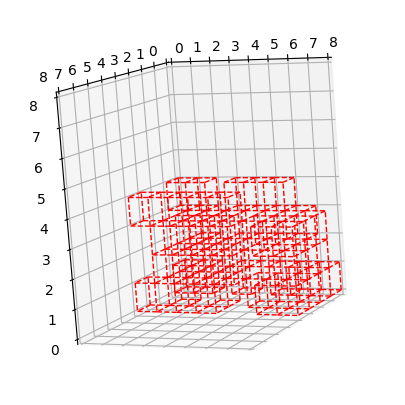

In [92]:
draw(coord, elcon0,25,80,-90,'red')

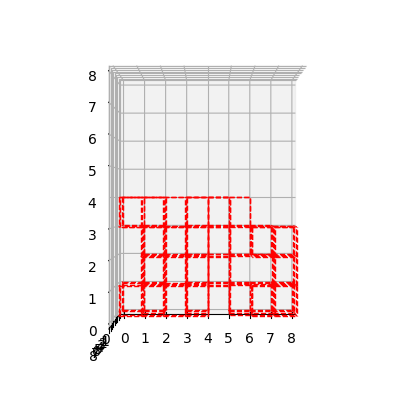

In [85]:
draw(coord, elcon0,0,90,-90,'red')

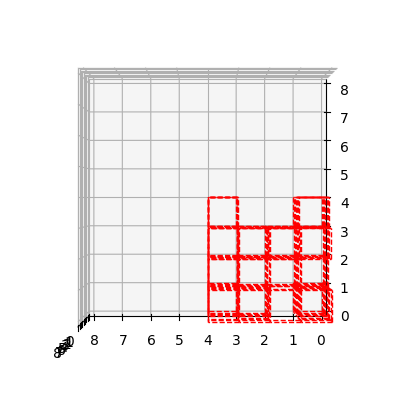

In [96]:
draw(coord, elcon0,90,90,-90,'red')

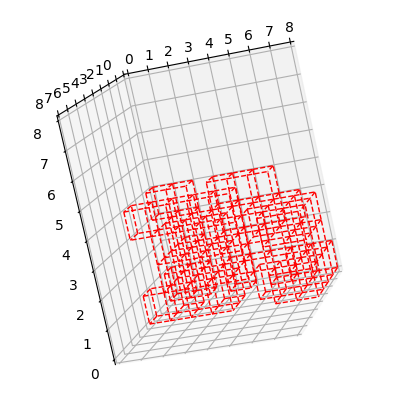

In [98]:
draw(coord, elcon0,15,80,-80,'red')